In [68]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [69]:
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [70]:
data = pd.read_csv('stock_data.csv')
# data = data.iloc[:262, :]
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,5.398742,5.427103,5.368389,5.392273,141556000,0.0,0.0
1,5.389280,5.402725,4.988682,5.282470,1527812000,0.0,0.0
2,5.259566,5.700996,5.250852,5.576758,1561116000,0.0,0.0
3,5.624310,5.985073,5.596176,5.959678,2034124000,0.0,0.0
4,5.988310,6.020428,5.871044,5.897435,931420000,0.0,0.0
...,...,...,...,...,...,...,...
257,143.000000,143.139999,132.110001,135.399994,987765800,0.0,0.0
258,137.210007,149.770004,135.570007,147.630005,973098600,0.0,0.0
259,148.679993,149.649994,140.080002,141.979996,1017459800,0.0,0.0
260,139.500000,152.889999,137.149994,141.949997,1396925400,0.0,0.0


In [71]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values
# x = data.iloc[:, :32].values
# y = data.iloc[:, 32].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (209, 7) trainY: (209,)
testX: (53, 7) testY: (53,)


In [72]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super().__init__()
        
        # Encoder
        self.encoder_layers = nn.ModuleList()
        current_dim = input_dim
        
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                nn.Sequential(
                    nn.Linear(current_dim, hidden_dim),
                    nn.ReLU()
                )
            )
            current_dim = hidden_dim
            
        self.fc_mu = nn.Linear(hidden_dims[-1], latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1])
        
        self.decoder_layers = nn.ModuleList()
        reversed_dims = list(reversed(hidden_dims))
        
        for i in range(len(reversed_dims) - 1):
            self.decoder_layers.append(
                nn.Sequential(
                    nn.Linear(reversed_dims[i], reversed_dims[i + 1]),
                    nn.ReLU()
                )
            )
            
        # Final output layer
        self.final_layer = nn.Sequential(
            nn.Linear(reversed_dims[-1], input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        for layer in self.encoder_layers:
            x = layer(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        for layer in self.decoder_layers:
            x = layer(x)
        return self.final_layer(x)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), z, mu, log_var

In [73]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
# first one must be the number of columns
model = VAE(input_dim=7, hidden_dims=[325, 65, 389,12], latent_dim=13)

In [74]:
num_epochs = 500
learning_rate = 9.587597851425012e-05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    loss_ = []
    for (x, ) in train_loader:
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print(f'[{epoch+1}/{num_epochs}] Loss:', sum(loss_))

[1/500] Loss: 64.94616317749023
[2/500] Loss: 63.478342056274414
[3/500] Loss: 62.06490516662598
[4/500] Loss: 60.68195152282715
[5/500] Loss: 59.309181213378906
[6/500] Loss: 57.928436279296875
[7/500] Loss: 56.5504207611084
[8/500] Loss: 55.16627883911133
[9/500] Loss: 53.80464172363281
[10/500] Loss: 52.47999382019043
[11/500] Loss: 51.25195121765137
[12/500] Loss: 50.13747215270996
[13/500] Loss: 49.13313674926758
[14/500] Loss: 48.188209533691406
[15/500] Loss: 47.297340393066406
[16/500] Loss: 46.477609634399414
[17/500] Loss: 45.74519920349121
[18/500] Loss: 45.10734558105469
[19/500] Loss: 44.579336166381836
[20/500] Loss: 44.187355041503906
[21/500] Loss: 43.94558334350586
[22/500] Loss: 43.87592315673828
[23/500] Loss: 43.99736213684082
[24/500] Loss: 44.30891036987305
[25/500] Loss: 44.80472946166992
[26/500] Loss: 45.44969367980957
[27/500] Loss: 46.186561584472656
[28/500] Loss: 46.94667625427246
[29/500] Loss: 47.64568328857422
[30/500] Loss: 48.208600997924805
[31/500] L

In [75]:
# model.eval()
# _, VAE_train_x, _, _ = model(torch.from_numpy(train_x_denoised).float().to(device))
# _, VAE_test_x, _, _ = model(torch.from_numpy(test_x_denoised).float().to(device))
model.eval()
_, VAE_train_x, _, _ = model(torch.from_numpy(train_x).float())
_, VAE_test_x, _, _ = model(torch.from_numpy(test_x).float())

In [76]:
def time_series_window(x, y, window_size):
    """
    Args:
        x: Input features array, shape (n_samples, n_features)
        y: Target values array, shape (n_samples, 1)
        window_size: Size of the sliding window
        
    Returns:
        tuple: (
            windowed_x: Feature windows, shape (n_samples-window, window_size, n_features)
            windowed_y: Single target values, shape (n_samples-window, 1)
            windowed_y_gan: Target windows, shape (n_samples-window, window_size+1, 1)
        )
    """
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    if not isinstance(y, np.ndarray):
        y = np.array(y)
        
    n_samples = len(x) - window_size
    
    windowed_x = np.zeros((n_samples, window_size, x.shape[1]))
    windowed_y = np.zeros((n_samples, 1))
    windowed_y_gan = np.zeros((n_samples, window_size + 1, 1))
    
    for i in range(n_samples):
        windowed_x[i] = x[i:i + window_size]
        windowed_y[i] = y[i + window_size]
        windowed_y_gan[i] = y[i:i + window_size + 1]
    
    return (torch.from_numpy(windowed_x).float(),
            torch.from_numpy(windowed_y).float(),
            torch.from_numpy(windowed_y_gan).float())

In [77]:
train_x_combined = np.concatenate((train_x, VAE_train_x.detach().numpy()), axis=1)
test_x_combined = np.concatenate((test_x, VAE_test_x.detach().numpy()), axis=1)

In [78]:
train_x_slide, train_y_slide, train_y_gan = time_series_window(train_x_combined, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = time_series_window(test_x_combined, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([206, 3, 20]) train_y: torch.Size([206, 1]) train_y_gan: torch.Size([206, 4, 1])
test_x: torch.Size([50, 3, 20]) test_y: torch.Size([50, 1]) test_y_gan: torch.Size([50, 4, 1])


In [79]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm_1 = nn.LSTM(input_size, 222, batch_first=True)  # Changed to 222
        self.lstm_2 = nn.LSTM(222, 69, batch_first=True)         # Changed to 69
        self.lstm_3 = nn.LSTM(69, 187, batch_first=True)         # Changed to 187
        self.linear_1 = nn.Linear(187, 64)
        self.linear_2 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.27478243816226433)           # New dropout rate

    def forward(self, x):
        h0, c0 = (torch.zeros(1, x.size(0), 222), torch.zeros(1, x.size(0), 222))
        out_1, _ = self.lstm_1(x, (h0, c0))
        out_1 = self.dropout(out_1)

        h1, c1 = (torch.zeros(1, x.size(0), 69), torch.zeros(1, x.size(0), 69))
        out_2, _ = self.lstm_2(out_1, (h1, c1))
        out_2 = self.dropout(out_2)

        h2, c2 = (torch.zeros(1, x.size(0), 187), torch.zeros(1, x.size(0), 187))
        out_3, _ = self.lstm_3(out_2, (h2, c2))
        out_3 = self.dropout(out_3)

        out_4 = self.linear_1(out_3[:, -1, :])
        out = self.linear_2(out_4)
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(1, 300, num_layers=4, batch_first=True, nonlinearity="relu")  # Changed to 300 hidden, 4 layers
        self.dropout = nn.Dropout(0.23279185573832029)  # New dropout rate
        self.linear = nn.Linear(300, 1)

    def forward(self, x):
        h0 = torch.zeros(4, x.size(0), 300)  # Changed to match 4 layers and 300 hidden units
        out, _ = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.linear(out[:, -1, :])
        return torch.sigmoid(out)

In [80]:
batch_size = 32  # This was already optimal
num_epochs = 130  # This can stay the same
# Remove the single learning_rate variable since we have separate rates now
trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size=batch_size, shuffle=False)

# modelG = Generator(17)
modelG = Generator(train_x_combined.shape[1]) 
modelD = Discriminator()

criterion = nn.BCELoss()
# Use the optimized learning rates
learning_rate_G = 0.0001308073246144895  # New value
learning_rate_D = 0.0004889549482873152  # New value
optimizerG = torch.optim.Adam(modelG.parameters(), lr=learning_rate_G, betas=(0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr=learning_rate_D, betas=(0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)

for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis=1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output)
        lossD_real = criterion(dis_real_output, real_labels)

        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')


[1/130] LossD: 9.70133900642395 LossG:4.890825629234314
[2/130] LossD: 9.65963363647461 LossG:4.843722581863403
[3/130] LossD: 9.57101047039032 LossG:4.894376039505005
[4/130] LossD: 9.561973452568054 LossG:4.929453611373901
[5/130] LossD: 9.682719945907593 LossG:4.940359115600586
[6/130] LossD: 9.708187937736511 LossG:4.8649139404296875
[7/130] LossD: 9.752316355705261 LossG:4.865297734737396
[8/130] LossD: 9.726109266281128 LossG:4.863882660865784
[9/130] LossD: 9.700732827186584 LossG:4.874548614025116
[10/130] LossD: 9.587130069732666 LossG:4.95603483915329
[11/130] LossD: 9.444714069366455 LossG:5.018266141414642
[12/130] LossD: 9.252533674240112 LossG:5.105854511260986
[13/130] LossD: 9.19769275188446 LossG:5.154512107372284
[14/130] LossD: 9.0487779378891 LossG:5.45441871881485
[15/130] LossD: 8.742342591285706 LossG:5.687535643577576
[16/130] LossD: 8.442146182060242 LossG:6.240992903709412
[17/130] LossD: 7.9311084151268005 LossG:6.827963352203369
[18/130] LossD: 7.27748435735

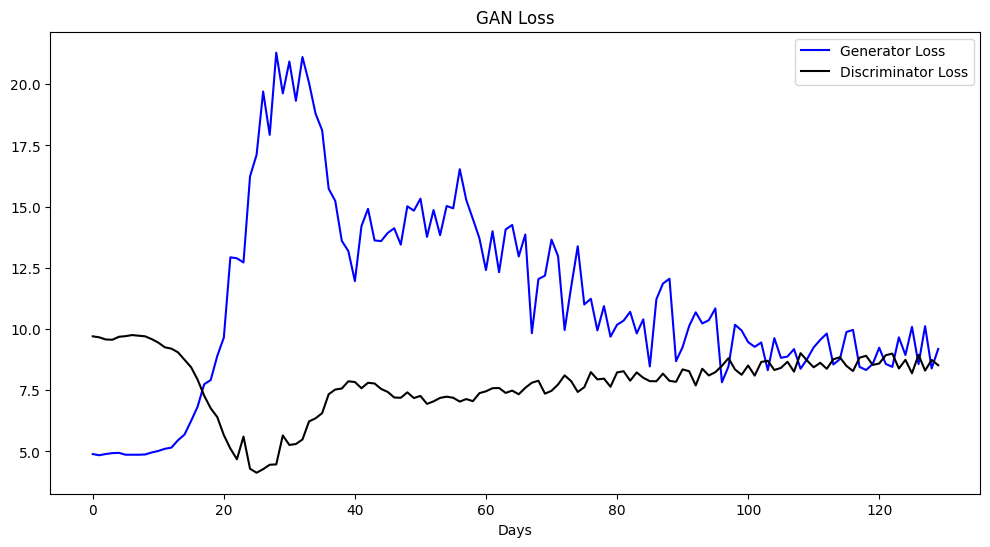

In [81]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [82]:
modelG.eval()
pred_y_train = modelG(train_x_slide)
pred_y_test = modelG(test_x_slide)

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.detach().numpy())

y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.detach().numpy())

Training dataset RMSE:2.481017492208322


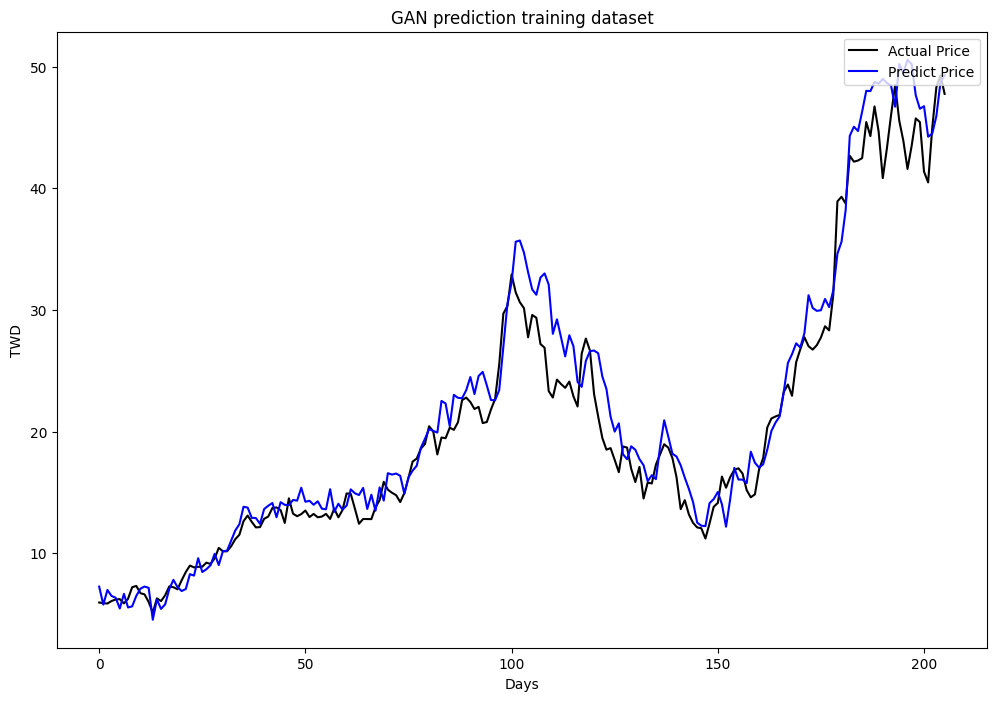

In [83]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:24.46494481788991


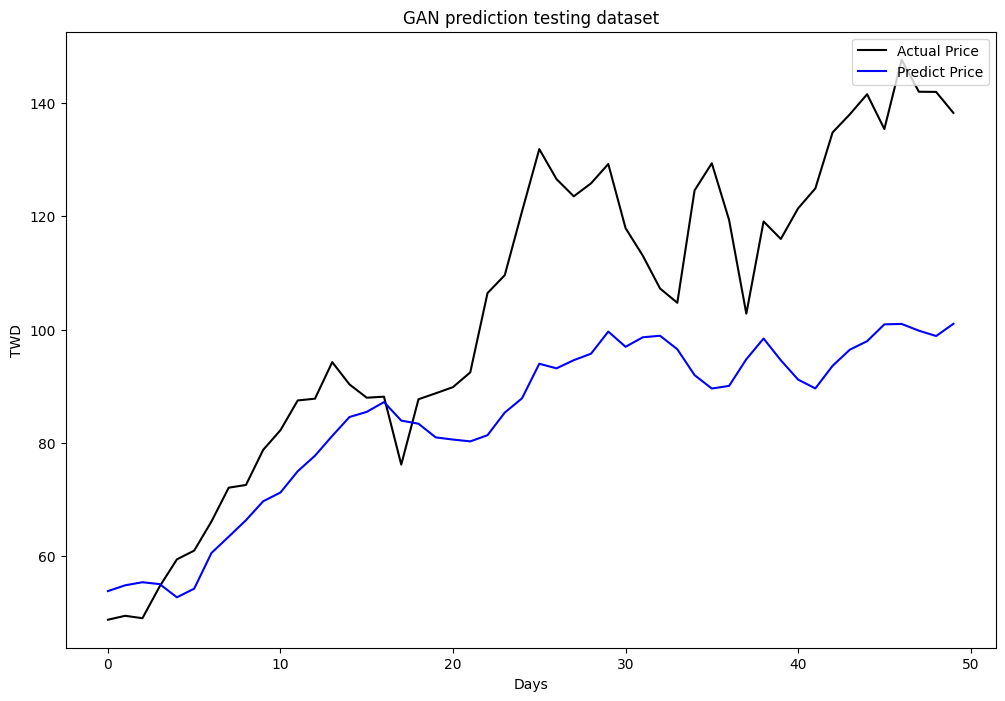

In [84]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')